# LA County voting center locations

### Load python tools

In [1]:
import pandas as pd
import geopandas as gpd
from urllib.request import urlopen 
import pyarrow
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
import altair as alt
# alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
plt.rcParams['figure.figsize'] = (16,8)
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()
pd.options.display.float_format = '{:,.8f}'.format

### Read data downloaded from RRCC office

In [84]:
# https://locator.lavote.net/locations/vc
# https://locator.lavote.net/getLocations?id=3&electionId=4085
src = pd.read_json('input/get_locations.json', dtype=False)

In [85]:
src.columns = src.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [86]:
src.loc[0]

locationid                                                            6164
locationtypecode                                                         3
electionid                                                            4085
name                                        122nd Street Elementary School
address                                                     405 E 122nd St
city                                                           Los Angeles
state                                                                   CA
zipcode                                                              90061
hours                    February 29 - March 2: 8AM - 5PM<br>March 3: 7...
parkingarea                                                           None
isactive                                                              None
iscancelled                                                           None
additionalinformation                                           Auditorium
votingperiod             

---

---

### Convert vote center locations to a geodataframe

In [87]:
locations_geo = gpd.GeoDataFrame(src, geometry=gpd.points_from_xy\
                               (src['longitude'], src['latitude']))

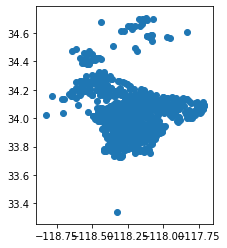

In [88]:
locations_geo.plot()

### What's in the dataframe?

In [115]:
locations_geo['full_address'] = locations_geo['address'] \
    + ', ' + locations_geo['city'] \
    + ', ' + locations_geo['zipcode']

In [116]:
locations_geo['eleven'] = locations_geo['hours'].str.contains('February 22')
locations_geo['four'] = locations_geo['hours'].str.contains('February 29')

In [117]:
locations_geo.loc[0]

locationid                                                            6164
locationtypecode                                                         3
electionid                                                            4085
name                                        122nd Street Elementary School
address                                                     405 E 122nd St
city                                                           Los Angeles
state                                                                   CA
zipcode                                                              90061
hours                    February 29 - March 2: 8AM - 5PM<br>March 3: 7...
parkingarea                                                           None
isactive                                                              None
iscancelled                                                           None
additionalinformation                                           Auditorium
votingperiod             

### Change coordinate system

In [118]:
locations_geo.crs = {'init': "epsg:4326"}

In [119]:
locations_geo.to_file('output/locations_geo.geojson', driver='GeoJSON')

In [143]:
locations_geo[['name', 'address', 'city', 'zipcode', 'full_address', 'votingperiod', 'additionalinformation']]\
    .to_csv('/Users/mhustiles/data/github/bigbuilder/bigbuilder/pages/la-vote-center-locations/data/centers.csv',\
            sep=',', index=False)

### How many days are the locations open? 

In [11]:
fourdays = locations_geo[locations_geo['votingperiod'] == 4]
elevendays = locations_geo[locations_geo['votingperiod'] == 11]

### 4 days vs. 11 days

In [12]:
locations_geo.groupby(['votingperiod'])\
    .agg('size').reset_index(name='count').sort_values(by='count', ascending=False)

votingperiod  count
0             4    709
1            11    192

### What share are open only 4 days? 

In [13]:
"{:.2%}".format(len(fourdays) / (len(elevendays) + len(fourdays)))

'78.69%'

### Where are the four-day locations? 

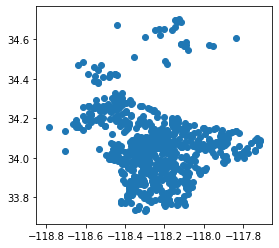

In [14]:
(locations_geo[locations_geo['votingperiod'] == 4]).plot()

### Where are the 11-day locations? 

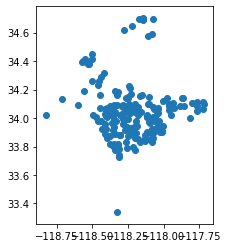

In [15]:
(locations_geo[locations_geo['votingperiod'] == 11]).plot()

---

### How many by LA County neighborhood/city/community? 

In [16]:
hoods = gpd.read_file('input/la-county-city-neighborhoods.geojson')

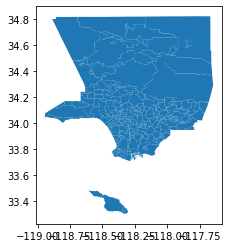

In [132]:
hoods.plot()

In [133]:
hoods.crs = {'init': "epsg:4326"}

### Join with vote center locations and clean up dataframe

In [138]:
hoods_centers = gpd.sjoin(locations_geo, hoods,op='within', how="inner")
hoods_centers = hoods_centers.drop(['electionid','isactive','isactive',\
                    'name_left','parkingarea','state','index_right',\
                    'set','kind','external_i','display_na','name_1','slug_1', 'slug'], axis=1)

In [139]:
hoods_centers['additionalinformation'] = hoods_centers['additionalinformation'].str.capitalize()

In [140]:
hoods_centers = hoods_centers.rename(columns={'name_right':'name','0':'before_hours', '1': 'election_day_hours'})

### Export to map file

In [24]:
hoods_centers.to_file('output/hoods_centers.geojson', driver='GeoJSON')

In [141]:
!tippecanoe --force -zg -r1 -pk -pf -o \
output/hoods_centers.mbtiles \
output/hoods_centers.geojson

For layer 0, using name "hoods_centers"
901 features, 67016 bytes of geometry, 16 bytes of separate metadata, 62485 bytes of string pool
Choosing a maxzoom of -z6 for features about 5819 feet (1774 meters) apart
  99.9%  6/10/25  


In [26]:
hoods_centers.head()

locationid  locationtypecode                address         city zipcode  \
0          6164                 3         405 E 122nd St  Los Angeles   90061   
7          6319                 3  150 E El Segundo Blvd  Los Angeles   90061   
263        6678                 3       13055 Clovis Ave  Los Angeles   90059   
267        6561                 3     7600 S Avalon Blvd  Los Angeles   90001   
307        6062                 3        1400 E 118th St  Los Angeles   90059   

                                                 hours iscancelled  \
0    February 29 - March 2: 8AM - 5PM<br>March 3: 7...        None   
7    February 29 - March 2: 8AM - 5PM<br>March 3: 7...        None   
263  February 29 - March 2: 8AM - 5PM<br>March 3: 7...        None   
267  February 29 - March 2: 8AM - 5PM<br>March 3: 7...        None   
307  February 29 - March 2: 8AM - 5PM<br>March 3: 7...        None   

        additionalinformation  votingperiod    latitude     longitude  \
0                  Auditorium             4 33.92190335 -118.26853753   
7                Meeting room             4 33.91638543 -118.27229267   
263  Small multi-purpose room             4 33.91347849 -118.25796936   
267        Multi-purpose room             4 33.90698863 -118.26501082   
307            Community room             4 33.92614452 -118.25060279   

                        geometry         name           sqmi  \
0    POINT (-118.26854 33.92190)  Willowbrook  3.76636072646   
7    POINT (-118.27229 33.91639)  Willowbrook  3.76636072646   
263  POINT (-118.25797 33.91348)  Willowbrook  3.76636072646   
267  POINT (-118.26501 33.90699)  Willowbrook  3.76636072646   
307  POINT (-118.25060 33.92614)  Willowbrook  3.76636072646   

                    type  
0    unincorporated-area  
7    unincorporated-area  
263  unincorporated-area  
267  unincorporated-area  
307  unincorporated-area

### Group by location name

In [27]:
hoods_centers_grouped = hoods_centers.groupby(['name'])\
    .agg('size').reset_index(name='count').sort_values(by='count', ascending=False)

In [78]:
hoods_centers_grouped.head(100)

name  count
113                Long Beach     31
187                  Torrance     24
70                   Glendale     18
167             Santa Clarita     18
207               West Covina     17
144                  Pasadena     17
59                   El Monte     15
106                 Lancaster     14
30                     Carson     13
27                    Burbank     13
136                   Norwalk     12
149                    Pomona     11
56           East Los Angeles     11
145               Pico Rivera     10
91                  Inglewood     10
43                    Compton     10
176                South Gate     10
55             East Hollywood      9
139                  Palmdale      9
24              Boyle Heights      9
44                     Covina      9
184                    Sylmar      9
217                  Whittier      9
155             Redondo Beach      8
105                  Lakewood      8
49                Diamond Bar      8
218               Willowbrook      8
214                  Westlake      8
169              Santa Monica      8
71                   Glendora      7
86                  Hollywood      7
36                   Cerritos      7
60                 El Segundo      7
50                     Downey      7
213               Westchester      7
68                    Gardena      7
196                    Venice      7
51                   Downtown      6
125              Mid-Wilshire      6
130             Monterey Park      6
73              Granada Hills      6
143                 Paramount      6
84              Highland Park      6
162              San Fernando      6
181                Sun Valley      6
17               Baldwin Park      6
179            South Whittier      6
41                  Claremont      6
20               Bell Gardens      5
220                  Winnetka      5
6                    Altadena      5
94                  Koreatown      5
61                  El Sereno      5
166                 San Pedro      5
221            Woodland Hills      5
138                   Pacoima      5
133           North Hollywood      5
128                Montebello      5
154       Rancho Palos Verdes      5
48                    Del Rey      5
89                  Hyde Park      4
219                Wilmington      4
132               North Hills      4
212  West Whittier-Los Nietos      4
88            Huntington Park      4
205                West Adams      4
159                  Rosemead      4
204                     Watts      4
127                  Monrovia      4
81                  Hawthorne      4
107                  Lawndale      4
156                    Reseda      4
170                  Sawtelle      4
124                  Mid-City      4
135                Northridge      4
111           Lincoln Heights      4
33            Castaic Canyons      4
64            Exposition Park      4
37                 Chatsworth      4
28                  Calabasas      4
40                  Chinatown      4
46                Culver City      4
52                     Duarte      4
53                 Eagle Rock      4
21                 Bellflower      4
58                  Echo Park      4
15                      Azusa      4
34            Central-Alameda      4
4                    Alhambra      4
216                  Westwood      3
67         Florence-Firestone      3
160           Rowland Heights      3
147                Pico-Union      3
16     Baldwin Hills/Crenshaw      3
180               Studio City      3
115                 Los Feliz      3
116                   Lynwood      3
163               San Gabriel      3
63                     Encino      3
19                       Bell      3

In [ ]:
hoods_choropleth = gpd.GeoDataFrame\
    (pd.merge(hoods_centers_grouped, hoods, on='name', how='outer'), geometry='geometry')

In [127]:
hoods_choropleth['count'] = hoods_choropleth['count'].fillna('0').astype(float)

In [144]:
hoods_choropleth.head()

name       count           slug  \
0     Long Beach 31.00000000     long-beach   
1       Torrance 24.00000000       torrance   
2       Glendale 18.00000000       glendale   
3  Santa Clarita 18.00000000  santa-clarita   
4    West Covina 17.00000000    west-covina   

                                   set                                kind  \
0  L.A. County Neighborhoods (Current)  L.A. County Neighborhood (Current)   
1  L.A. County Neighborhoods (Current)  L.A. County Neighborhood (Current)   
2  L.A. County Neighborhoods (Current)  L.A. County Neighborhood (Current)   
3  L.A. County Neighborhoods (Current)  L.A. County Neighborhood (Current)   
4  L.A. County Neighborhoods (Current)  L.A. County Neighborhood (Current)   

      external_i                                        display_na  \
0     long-beach     Long Beach L.A. County Neighborhood (Current)   
1       torrance       Torrance L.A. County Neighborhood (Current)   
2       glendale       Glendale L.A. County Neighborhood (Current)   
3  santa-clarita  Santa Clarita L.A. County Neighborhood (Current)   
4    west-covina    West Covina L.A. County Neighborhood (Current)   

            sqmi             type name_1 slug_1  \
0  52.1003673205  standalone-city   None   None   
1  20.5832400164  standalone-city   None   None   
2  30.6279832578  standalone-city   None   None   
3  57.3513787685  standalone-city   None   None   
4  16.1145589195  standalone-city   None   None   

                                            geometry  
0  MULTIPOLYGON (((-118.16418 33.82768, -118.1610...  
1  MULTIPOLYGON (((-118.31327 33.88377, -118.3131...  
2  MULTIPOLYGON (((-118.23881 34.25250, -118.2388...  
3  MULTIPOLYGON (((-118.52471 34.47721, -118.5242...  
4  MULTIPOLYGON (((-117.94299 34.09249, -117.9397...

In [129]:
hoods_choropleth.to_file('output/hoods_choropleth.geojson', driver='GeoJSON')

In [130]:
!tippecanoe --force -r1 -pk -pf -Z7 -z14 -o \
output/hoods_choropleth.mbtiles \
output/hoods_choropleth.geojson

For layer 0, using name "hoods_choropleth"
272 features, 120261 bytes of geometry, 7720 bytes of separate metadata, 25263 bytes of string pool
  99.9%  14/2826/6539  


### How many will be open 4 vs 11 days?

In [29]:
hoods_centers_days = hoods_centers.groupby(['votingperiod'])\
    .agg('size').reset_index(name='count').sort_values(by='count', ascending=False)

In [30]:
hoods_centers_days.head(20)

votingperiod  count
0             4    709
1            11    192

### Which cities will the centers be open? How many in the city of L.A.? 

In [31]:
### This groups on the city location, not the neighborhood name
hoods_centers_cities = hoods_centers.groupby(['city'])\
    .agg('size').reset_index(name='count').sort_values(by='count', ascending=False)

In [32]:
hoods_centers_cities.head(10)

city  count
65     Los Angeles    223
64      Long Beach     31
125       Torrance     23
136       Whittier     20
88        Pasadena     18
134    West Covina     17
39        Glendale     16
58       Lancaster     15
107  Santa Clarita     14
35        El Monte     14

In [33]:
hoods_centers_areas = hoods_centers.groupby(['type'])\
    .agg('size').reset_index(name='count').sort_values(by='count', ascending=False)

In [34]:
hoods_centers_areas.head()

type  count
1      standalone-city    494
0    segment-of-a-city    309
2  unincorporated-area     98

In [35]:
hoods_centers_places = hoods_centers.groupby(['additionalinformation'])\
    .agg('size').reset_index(name='count').sort_values(by='count', ascending=False)

In [36]:
hoods_centers_places.head(5)

additionalinformation  count
18             Auditorium    140
177    Multi-purpose room    112
171          Meeting room     50
77         Community room     48
48              Cafeteria     40

### How many by supervisoral district? 

In [37]:
supes = gpd.read_file('input/la_county_gis_supervisors_1566093928265.geojson')

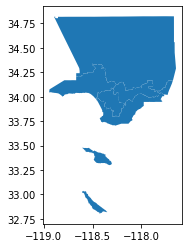

In [38]:
supes.plot()

In [39]:
supes_centers = gpd.sjoin(locations_geo, supes,op='within', how="inner")

In [40]:
supes_centers.groupby('LABEL').agg('size').reset_index(name='count').sort_values(by='count', ascending=False)

LABEL  count
0  District 1    208
3  District 4    187
4  District 5    186
1  District 2    172
2  District 3    148

In [41]:
supes_centers.head()

locationid  locationtypecode  electionid                            name  \
0        6164                 3        4085  122nd Street Elementary School   
1        6075                 3        4085  153rd Street Elementary School   
2        6143                 3        4085  186th Street Elementary School   
3        6472                 3        4085   232nd Place Elementary School   
5        6515                 3        4085          42nd Street Elementary   

               address         city state zipcode  \
0       405 E 122nd St  Los Angeles    CA   90061   
1      1605 W 153rd St      Gardena    CA   90247   
2      1581 W 186th St      Gardena    CA   90248   
3  23240 Archibald Ave       Carson    CA   90745   
5         4231 4th Ave  Los Angeles    CA   90008   

                                               hours parkingarea isactive  \
0  February 29 - March 2: 8AM - 5PM<br>March 3: 7...        None     None   
1  February 29 - March 2: 8AM - 5PM<br>March 3: 7...        None     None   
2  February 29 - March 2: 8AM - 5PM<br>March 3: 7...        None     None   
3  February 29 - March 2: 8AM - 5PM<br>March 3: 7...        None     None   
5  February 29 - March 2: 8AM - 5PM<br>March 3: 7...        None     None   

  iscancelled additionalinformation  votingperiod    latitude     longitude  \
0        None            Auditorium             4 33.92190335 -118.26853753   
1        None            Auditorium             4 33.89354284 -118.30588352   
2        None            Auditorium             4 33.86209658 -118.30536302   
3        None            Auditorium             4 33.81452907 -118.28246638   
5        None            Auditorium             4 34.00661367 -118.32141343   

                      geometry  index_right  OBJECTID DISTRICT       LABEL  \
0  POINT (-118.26854 33.92190)            1       816        2  District 2   
1  POINT (-118.30588 33.89354)            1       816        2  District 2   
2  POINT (-118.30536 33.86210)            1       816        2  District 2   
3  POINT (-118.28247 33.81453)            1       816        2  District 2   
5  POINT (-118.32141 34.00661)            1       816        2  District 2   

          Shape.STArea()  Shape.STLength()  
0 4,511,283,068.88867188  477,421.59266201  
1 4,511,283,068.88867188  477,421.59266201  
2 4,511,283,068.88867188  477,421.59266201  
3 4,511,283,068.88867188  477,421.59266201  
5 4,511,283,068.88867188  477,421.59266201

---

In [42]:
precincts = gpd.read_file('/Users/mhustiles/data/github/la-county-2016-primary-precinct-maps/Consolidations.shp')
precincts = precincts.rename(columns={'Cnsld':'precinct'})

In [43]:
precincts = precincts.to_crs({'init': "epsg:4326"})

In [44]:
precincts.head()

precinct  VBM  BallotGrou  SerialNumb  VBMVoters  NonVBMVote  \
0  9003465A    0          55        4184        240         355   
1  9000191A    0          54        2978        345         662   
2  6250095A    0          81        2406        578         837   
3  1770008E    1           2        6032         50          58   
4  3850208A    1         203        6081         92         209   

                                            geometry  
0  POLYGON ((-118.65729 34.19135, -118.65746 34.1...  
1  POLYGON ((-118.57105 34.23798, -118.57104 34.2...  
2  POLYGON ((-118.50183 34.01895, -118.50223 34.0...  
3  POLYGON ((-118.07958 34.51356, -118.07959 34.5...  
4  POLYGON ((-118.19252 33.84385, -118.19267 33.8...

### Read historic voting info from LA County Registrar-Recorder

In [45]:
#https://lavote.net/home/voting-elections/current-elections/election-results/past-election-results#06072016
primary = pd.read_excel('/Users/mhustiles/data/github/notebooks/voting/input/presidential_democratic_june_2016_precincts.xls')
general = pd.read_excel('/Users/mhustiles/data/github/notebooks/voting/input/presidential_november_2016_precincts.xls')

In [46]:
primary.head()

LOCATION  PRECINCT  SERIAL  BALLOT GROUP VOTE BY MAIL ONLY  REGISTRATION  \
0    ACTON  0050003A       1             2                 N           222   
1    ACTON  0050003A       1             2                 N             0   
2    ACTON  0050003A       1             2                 N           222   
3    ACTON  0050004B       2             2                 N           116   
4    ACTON  0050004B       2             2                 N             0   

            TYPE  BALLOTS CAST  KEITH JUDD  MICHAEL STEINBERG  BERNIE SANDERS  \
0  POLLING PLACE            92           2                  0              47   
1    VBM PORTION            44           0                  0              21   
2          TOTAL           136           2                  0              68   
3  POLLING PLACE            47           0                  0              29   
4    VBM PORTION            36           0                  0              18   

   WILLIE WILSON  ROQUE DE LA FUENTE  HILLARY CLINTON  HENRY HEWES Unnamed: 15  
0              0                   0               41            0              
1              0                   0               20            1              
2              0                   0               61            1              
3              0                   0               17            0              
4              0                   0               17            0

In [47]:
primary.columns = primary.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [48]:
general.columns = general.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [49]:
primary_slim = primary[['location','precinct','serial','ballot_group',\
                        'vote_by_mail_only','registration','type','ballots_cast']]

In [50]:
general_slim = general[['location','precinct','serial','ballot_group',\
                        'vote_by_mail_only','registration','type','ballots_cast']]

In [51]:
general_slim.head()

location  precinct  serial  ballot_group vote_by_mail_only  registration  \
0    ACTON  0050001E    6001            11                 Y             0   
1    ACTON  0050001E    6001            11                 Y             0   
2    ACTON  0050001E    6001            11                 Y             0   
3    ACTON  0050002G    6002            72                 Y             0   
4    ACTON  0050002G    6002            72                 Y             0   

            type  ballots_cast  
0  POLLING PLACE             0  
1    VBM PORTION             0  
2          TOTAL             0  
3  POLLING PLACE             0  
4    VBM PORTION             0

In [52]:
primary_pivot = pd.pivot_table(primary_slim, values='ballots_cast',\
                               index=['precinct'], columns=['type'], aggfunc=np.sum).reset_index()
primary_pivot.columns = primary_pivot.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [53]:
general_pivot = pd.pivot_table(general_slim, values='ballots_cast',\
                               index=['precinct'], columns=['type'], aggfunc=np.sum).reset_index()
general_pivot.columns = general_pivot.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [54]:
primary_pivot['vbm_pct'] = ((primary_pivot['vbm_portion']/primary_pivot['total'])*100).fillna('0').astype(int)

In [55]:
general_pivot['vbm_pct'] = ((general_pivot['vbm_portion']/general_pivot['total'])*100).fillna('0').astype(int)

In [56]:
primary_pivot.head()

type  precinct  polling_place  total  vbm_portion  vbm_pct
0     0050003A             92    136           44       32
1     0050004B             47     83           36       43
2     0050005A             67    105           38       36
3     0050014A             49     85           36       42
4     0050022A              0      3            3      100

In [57]:
primary_precincts_2016 = gpd.GeoDataFrame(pd.merge(primary_pivot, precincts, on='precinct' ), geometry='geometry')

In [58]:
primary_precincts_2016 = primary_precincts_2016.drop(['VBM','BallotGrou',\
                                                      'SerialNumb','VBMVoters','NonVBMVote'], axis=1)

In [59]:
primary_precincts_2016.head()

precinct  polling_place  total  vbm_portion  vbm_pct  \
0  0050003A             92    136           44       32   
1  0050004B             47     83           36       43   
2  0050005A             67    105           38       36   
3  0050014A             49     85           36       42   
4  0050022A              0      3            3      100   

                                            geometry  
0  POLYGON ((-118.21968 34.46572, -118.21981 34.4...  
1  POLYGON ((-118.09356 34.46604, -118.09491 34.4...  
2  POLYGON ((-118.19716 34.46625, -118.19950 34.4...  
3  POLYGON ((-118.21444 34.42327, -118.21472 34.4...  
4  POLYGON ((-118.12900 34.37940, -118.13627 34.3...

In [60]:
primary_precincts_2016.to_file('output/primary_precincts_2016.geojson', driver='GeoJSON')